In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, BatchNormalization, Input
import tensorflow as tf
from keras import backend as K
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import random

# Определение функций

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Определение констант

In [3]:
SIGNAL_TRESHOLD = 200 #Определен опытным путем
RANDOM_STATE = 42

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Загрузка данных

In [5]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [6]:
y_train.head(3)

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0


# Скользящее среднее

Для каждого наблюдения определим начало изменения сигнала при помощи скользящего стандартного отклонения и модифицируем y_train исходя из новых данных. До начала жеста будем стовить класс 0, так как все наблюдения начинаются с жеста Open, после начала жеста будет стоять класс жеста.

In [7]:
# Пустой массив, размерности (323, 100)
modified_y_train = np.zeros((X_train.shape[0], 100))

# Определение информативных датчиков, уровень сигнала которых более 200
active_sensors = np.mean(X_train, axis=2) > SIGNAL_TRESHOLD
sensors_list = np.where(active_sensors[0])[0]


for id in range(X_train.shape[0]):
    # Конвертируем данные текущего наблюдения в DataFrame
    # для вычисления скользящего стандартного отклонения
    DF_X_train = pd.DataFrame(X_train[id]).T
    
    # Извлекаем верные ответы для текущего наблюдения
    y = y_train[id*100:(id+1)*100]['class'].values
    
    # Для каждого датчика в текущем наблюдении определим 
    # начало роста сигнала и изменим значения y_train
    if np.sum(y) != 0:
        # Строим скользящее стандартное отклонение
        DF_rw = DF_X_train.rolling(window=5).std().dropna(axis=0)

        # Рассчитываем начало времени выполнения жеста для каждого датчика
        mean_values = []
        
        for x in sensors_list:
            # Стандартное отклонение для текущего датчика
            rw_std = DF_rw[x].std()
            
            # Если есть значения, превышающее стандартное отклонение, определяем их индексы
            if (DF_rw[x] > rw_std).any():
                mean_values.append(np.nonzero((DF_rw[x] > rw_std).values)[0].mean())
        grow_ind = int(np.median(mean_values))

        # Преобразование строки y_train
        modified_y_train[id,:grow_ind] = y[0]
        modified_y_train[id,grow_ind:] = y[-1]

modified_y_train = np.array(modified_y_train)

print(modified_y_train.shape)


(323, 100)


# Преобразование данных

In [8]:
X_train = X_train.swapaxes(1, 2)
X_test = X_test.swapaxes(1, 2)

# Преобразуем модифицированный y_train в трехмерный массив
y_train = tf.keras.utils.to_categorical(modified_y_train)

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 100, 40) (323, 100, 9)
(54, 100, 40)


# LSTM

In [9]:
_, n_timesteps, n_channels = X_train.shape

output_units = y_train.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')


x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(
    kernel_initializer=initializer,
    units=100,
    return_sequences=True,
    activation='sigmoid',
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
)(x)
x = tf.keras.layers.LSTM(
    kernel_initializer=initializer,
    units=100,
    return_sequences=True,
    activation='sigmoid',
    dropout=0.5,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
)(x)
output = tf.keras.layers.Dense(kernel_initializer=initializer, units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (100, 40) | output_units = 9
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 40)]         0         
                                                                 
 batch_normalization (BatchN  (None, 100, 40)          160       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100, 100)          56400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dense (Dense)               (None, 100, 9)            909       
                                                                 
Total params: 137,869
Trainable params: 137,789
Non-trainable params: 80
___________

In [10]:
m = tf.keras.models.clone_model(model)
m.compile(
    loss="mean_squared_error",
    metrics=['accuracy', Precision(), Recall(), f1_m],
    optimizer=tf.keras.optimizers.Adam(),
)

history = m.fit(
    X_train,
    y_train, 
    epochs=800,
    validation_split=0.15,
    verbose=1,
    # batch_size=5,
    # callbacks=[early_stopping]
)

Epoch 1/800
9/9 [==============================] - 7s 297ms/step - loss: 4.7661 - accuracy: 0.5161 - precision: 0.8933 - recall: 0.0049 - f1_m: 0.0153 - val_loss: 4.1022 - val_accuracy: 0.5610 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/800
9/9 [==============================] - 2s 209ms/step - loss: 3.6818 - accuracy: 0.5792 - precision: 0.6028 - recall: 0.5391 - f1_m: 0.5690 - val_loss: 3.1592 - val_accuracy: 0.5610 - val_precision: 0.7031 - val_recall: 0.4939 - val_f1_m: 0.5826
Epoch 3/800
9/9 [==============================] - 2s 210ms/step - loss: 2.8269 - accuracy: 0.5792 - precision: 0.5972 - recall: 0.5684 - f1_m: 0.5867 - val_loss: 2.4210 - val_accuracy: 0.5610 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/800
9/9 [==============================] - 2s 210ms/step - loss: 2.1538 - accuracy: 0.5792 - precision: 0.7142 - recall: 0.5167 - f1_m: 0.6020 - val_loss: 1.8488 - val_accuracy: 0.5610 - val_precis

In [11]:
y_pred_train_nn = m.predict(X_train)

print(y_pred_train_nn.shape)

11/11 [==============================] - 1s 76ms/step
(323, 100, 9)


In [12]:
m.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.012490964>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.98142856>,
 'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.9818219>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.9810204>,
 'f1_m': <tf.Tensor: shape=(), dtype=float32, numpy=0.98129344>}

# Визуализация

Text(0.5, 1.0, 'Loss')

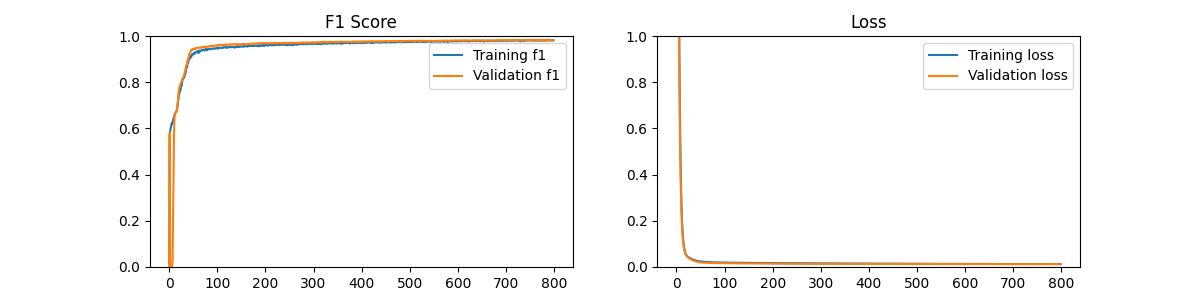

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

ax[0].plot(history.history['f1_m'], label='Training f1')
ax[0].plot(history.history['val_f1_m'], label='Validation f1')
ax[0].legend()
ax[0].set_ylim(0, 1)
ax[0].set_title('F1 Score')

ax[1].plot(history.history['loss'], label='Training loss')
ax[1].plot(history.history['val_loss'], label='Validation loss')
ax[1].legend()
ax[1].set_ylim(0, 1)
ax[1].set_title('Loss');

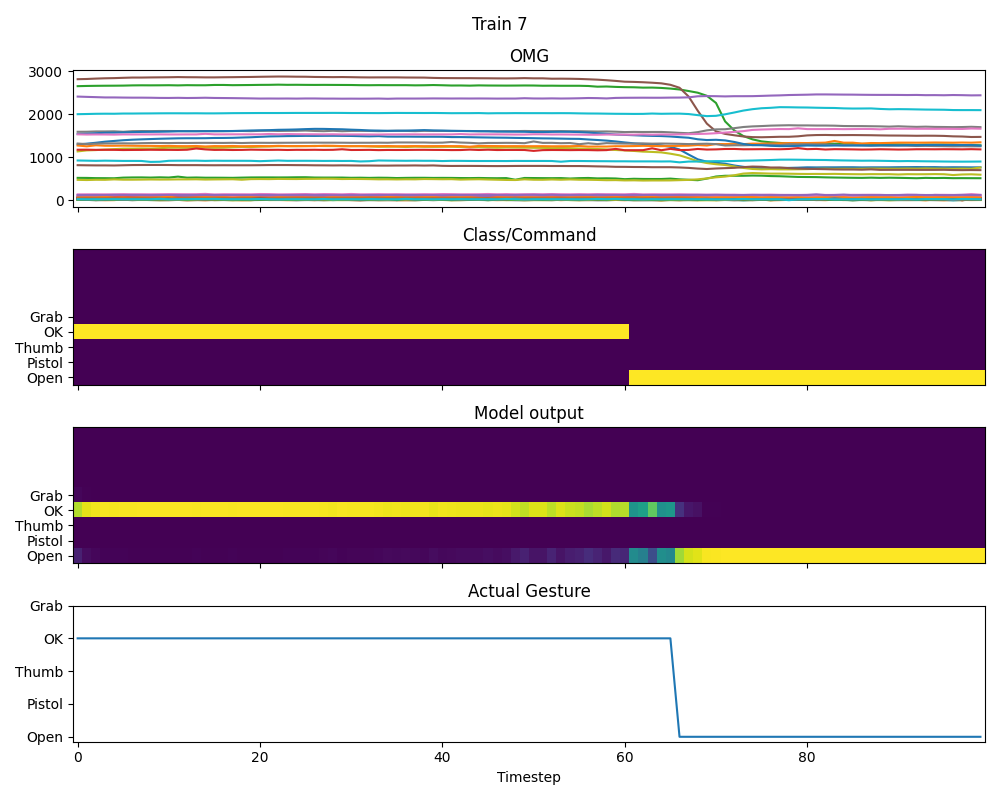

In [14]:
i = 7

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train[i])
axx[0].set_title('OMG')

axx[1].imshow(y_train[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')
plt.tight_layout()
plt.gcf();

# Предсказание на тестовых данных

In [15]:
y_pred_test_nn = m.predict(X_test)

2/2 [==============================] - 0s 56ms/step


In [19]:
print(y_pred_test_nn.shape)

(54, 100, 9)


In [21]:
y_pred_test = [arr.argmax(axis=-1) for arr in y_pred_test_nn]

In [22]:
len(y_pred_test)

54

In [26]:
y_pred_test_res = []

y_pred_test_res.extend(y_pred_test)

y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)

assert y_pred_test_res.shape[0] == y_test.shape[0]

# Формирование submission файла

In [28]:
y_test.head(3)

,sample-timestep,class
0,323-0,0
1,323-1,7
2,323-2,3


In [29]:
y_test_submit = y_test[['sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('classification_task_submit.csv', index=False)

y_test_submit.head(3)

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
